In [5]:
import requests,operator,pandas, glob2
from bs4 import BeautifulSoup

from datetime import datetime

In [6]:
import nltk
from konlpy.tag import Twitter
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/gulim.ttc").get_name()
rc('font', family=font_name)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

t=Twitter()



In [7]:
# 크롤링한 데이터 분석 함수
def analyze(content):
    # 매게변수로 전달받은 content 를 string 형태로 변경하고
    # 명사형으로 바꾸어 nouns 라는 변수에 저장
    nouns=t.nouns(str(content))

    # 더미데이터 제거
    trash=["조선","연합뉴스","일보","중앙","기자","뉴스","헤럴드경제"]
    for i in trash:
        for j in nouns:
            if i==j:
                nouns.remove(i)

    ko=nltk.Text(nouns,name="분석")

    #ranking이라는 변수를 사전형으로 변경
    ranking=ko.vocab().most_common(100)
    tmpData=dict(ranking)

    # 워드클라우드 설정
    wordcloud=WordCloud(font_path="C:/Windows/Fonts/gulim.ttc",
                        relative_scaling=0.2,background_color="white",).generate_from_frequencies(tmpData)

    #matplotlib 라이브러리를 통해 워드크라우드를 이미지 형식으로 보여줌nou
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


$ crawling
Enter news date : 20191019
Enter your pageCount : 10
Success Get DataFIle and Save Data
$ analyze
Enter your csv file name : 2019-10-21-5-56-45.csv
csv FIle Load Success


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


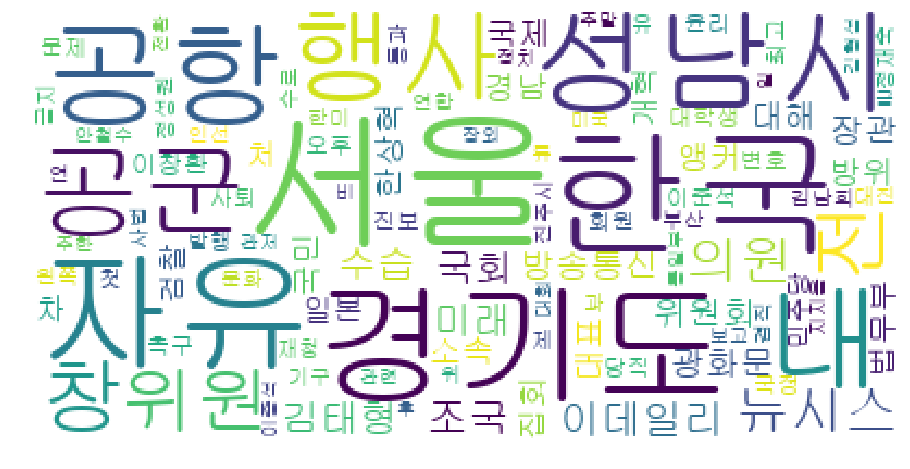

In [ ]:
# 크롤링 함수(날짜와 페이지수를 입력받아 그날짜의 그 페이지수만큼 크롤링 해옴)
def crawlingData(date, pageCount):

    # 현재 시각을 now라는 변수에 저장
    now = datetime.now()
    l = [] # 리스트 l

    # pagecount는 1페이지부터 사용자가 입력한 페이지 수까지 됨
    for pagecount in range(1, int(pageCount)):

        # 동적으로, 사용자가 입력한 날짜와 뉴스 페이지에 접속
        r = requests.get("http://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=100&date=" + str(date) + "&page=" + str(pagecount))
        c = r.content
        soup = BeautifulSoup(c, "html.parser")
        all = soup.find_all("li")

        for item in all:
            for item2 in item.find_all("dl"):
                d = {} # 사전 d
                try:
                    linkTag = item2.find("dt", {"class": ""}).find("a")
                    d["LinkSrc"] = linkTag['href'] # 사전 d의 LinkSrc라는 키에 href 내용을 가져와 저장
                    d["Title"] = linkTag.text.replace("\t", "").replace("\n", "").replace(",", "").replace('"',"").replace("\r", "")[1:len(linkTag.text) + 1]
                except:
                    d["LinkSrc"] = "None"
                    d["Title"] = "None"

                try:
                    contentTag = item2.find("dd")
                    d["Content"] = \
                    contentTag.text.replace("\t", "").replace("\n", "").replace("\r", "").replace(",", "").replace('"',"").split("…")[0]
                    d["Company"] = contentTag.find("span", {"class": "writing"}).text
                    d["Date"] = contentTag.find("span", {"class": "date"}).text
                except:
                    d["Content"] = "None"
                    d["Company"] = "None"
                    d["Date"] = "None"

                try:
                    imgTag = item2.find("dt", {"class": "photo"}).find("img")
                    d["imgSrc"] = imgTag["src"]
                except:
                    d["imgSrc"] = "No image"

                l.append(d) # 리스트에 사전 추가 / 한 행마다 사전에 추가

    df = pandas.DataFrame(l) # pandas 사용 l의 데이터프레임화

    # now(현재시각)을 이용해 csv 파일로 저장
    df.to_csv('%s-%s-%s-%s-%s-%s.csv' % (now.year, now.month, now.day, now.hour, now.minute, now.second),
              encoding='utf-8-sig', index=False)
    print("Success Get DataFIle and Save Data")


# loadFile 함수
def loadFile(fileName,analyzeValue):
    # checkFileName함수를 호출, 파일이 존재하나 존재하지 않는가 확인
    outputFileName = checkFileName(fileName)

    if outputFileName is not -1:
        df = pandas.read_csv(outputFileName)
        content = df["Content"]
        title = df["Title"]
        company = df["Company"]

        print("csv FIle Load Success")

        if analyzeValue==1:
            # analyze(title)
            analyze(content)

    else:
        print("Error csv File")

# checkFileName 함수
# 사용자가 입력한 파일명이 존재하지 않을시 -1 리턴, 존재시 파일명 리턴
# 사용자 입력값이 all이면 같은 경로의 모든 csv파일을 하나로 합치고, csv파일을 새로 만듦
# 그리고 만들어진 csv 파일을 리턴
def checkFileName(fileName):
    now = datetime.now()

    # 같은 경로에 csv 파일이 하나도 없다면 -1 리턴
    if len(glob2.glob("*.csv")) == 0:
        print("No file found in this directory")
        return -1
    else:
        # 사용자가 입력한 값이 all 이라면
        if fileName == "all":
            result = []
            # for 문을 돌며 모든 csv 파일을 가져와 읽은 후 result라는 리스트에 저장
            for i in glob2.glob("*.csv"):
                result.append(pandas.read_csv(i))

            # 새로 만들 파일이름 지정
            outputFileName = '%s-%s-%s-%s-%s-%s merging.csv' % (
                now.year, now.month, now.day, now.hour, now.minute, now.second)

            # 리스트에 저장한 csv파일들을 resultDf 라는 변수에 저장
            resultDf = pandas.concat(result, ignore_index=True)
            # csv 파일 생성
            resultDf.to_csv(outputFileName, encoding='utf-8-sig')
            # 새로만든 csv 파일의 이름을 리턴
            return outputFileName

        else:
            return fileName


# 메인 세팅 함수, 사용자로부터 값을 입력받아 함수를 호출
def mainSetting():
    while (1):
        kb = input("$ ")
        if kb == "exit":
            break
        elif kb == "crawling":
            date = input("Enter news date : ")
            page = input("Enter your pageCount : ")
            crawlingData(date, page)
        elif kb == "loadAll":
            loadFile("all",0)
        elif kb == "load":
            fileName = input("Enter your csv file name : ")
            loadFile(fileName,0)

        elif kb=="analyze":
            fileName = input("Enter your csv file name : ")
            loadFile(fileName,1)

        else:
            print("command error")


mainSetting()